In [1]:
import numpy as np
import time
import pandas as pd
from typing import Union
import matplotlib.pyplot as plt
import math

In [2]:
from ambientfisher.interpolators import AmbientFisherInterpolator
from ambientfisher.interpolators import PoissonAFInterpolator


In [3]:
anchors_simulated_points = [
                                ((0.0, 0.0), 5.0), 
                                ((1.0, 0.0), 7.0),  
                                ((-1.0, 0.0), 3.0), 
                                ((0.0, 1.0), 6.0),   
                                ((0.0, -1.0), 4.0), 
                            ]

anchor_alphas = np.array([alpha_point[0] for alpha_point in anchors_simulated_points])
anchor_nus = np.array([alpha_point[1] for alpha_point in anchors_simulated_points])


In [4]:
def poisson_pdf(nu):
    """
    Poisson pmf on a finite grid n=0..nmax using log form, then renormalize (truncation).
    """
    def pdf(n_obs):
        logp = n_obs * np.log(nu) - nu - np.vectorize(math.lgamma)(n_obs + 1)
        return np.exp(logp)
    return pdf

anchor_pdfs = [poisson_pdf(nu_anchor) for nu_anchor in anchor_nus]
xarray = np.arange(0, 25+1)

In [5]:
interp = AmbientFisherInterpolator(anchor_alphas, anchor_pdfs, xarray, plot_simplex=False)
interp_pois = PoissonAFInterpolator(anchor_alphas, anchor_nus, plot_simplex=False)

In [6]:
n_obs = np.array([5.0])

num_scan_points = 100

param_1_range = np.linspace(-1.0, 1.0, num=num_scan_points)
param_2_range = np.linspace(-1.0, 1.0, num=num_scan_points)

X, Y = np.meshgrid(param_1_range, param_2_range, indexing="xy")

AF_pred_extrinsic = np.full_like(X, np.nan, dtype=float)
AF_pred_intrinsic = np.full_like(X, np.nan, dtype=float)
AF_pred_poisson = np.full_like(X, np.nan, dtype=float)
mask = np.zeros_like(X, dtype=bool)

for i in range(num_scan_points):
    for j in range(num_scan_points):
        alpha_target = np.array([X[j, i], Y[j, i]])
        try:
            pe = interp.predict_extrinsic(alpha_target, xobs=n_obs)
            pe = float(np.squeeze(pe))
            if np.isfinite(pe) and pe > 0:
                AF_pred_extrinsic[j, i] = pe
                mask[j, i] = True
        except Exception:
            pass
        try:
            pi = interp.predict_intrinsic(alpha_target, xobs=n_obs)
            AF_pred_intrinsic[j, i] = pi
        except Exception:
            pass
        try:
            nu = interp_pois.predict(alpha_target)
            AF_pred_poisson[j, i] = poisson_pdf(nu)(n_obs)
        except Exception:
            pass


/home/jsandesara_umass_edu/histfactory_interpolation_tools/ambientfisher/utils.py:51: RuntimeWarning: invalid value encountered in arccos
  return 2.*np.sin( np.arccos( inner_product(q1, q2, xarray) ) /2. )
/tmp/ipykernel_2052576/2459118290.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  AF_pred_intrinsic[j, i] = pi
/tmp/ipykernel_2052576/2459118290.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  AF_pred_poisson[j, i] = poisson_pdf(nu)(n_obs)


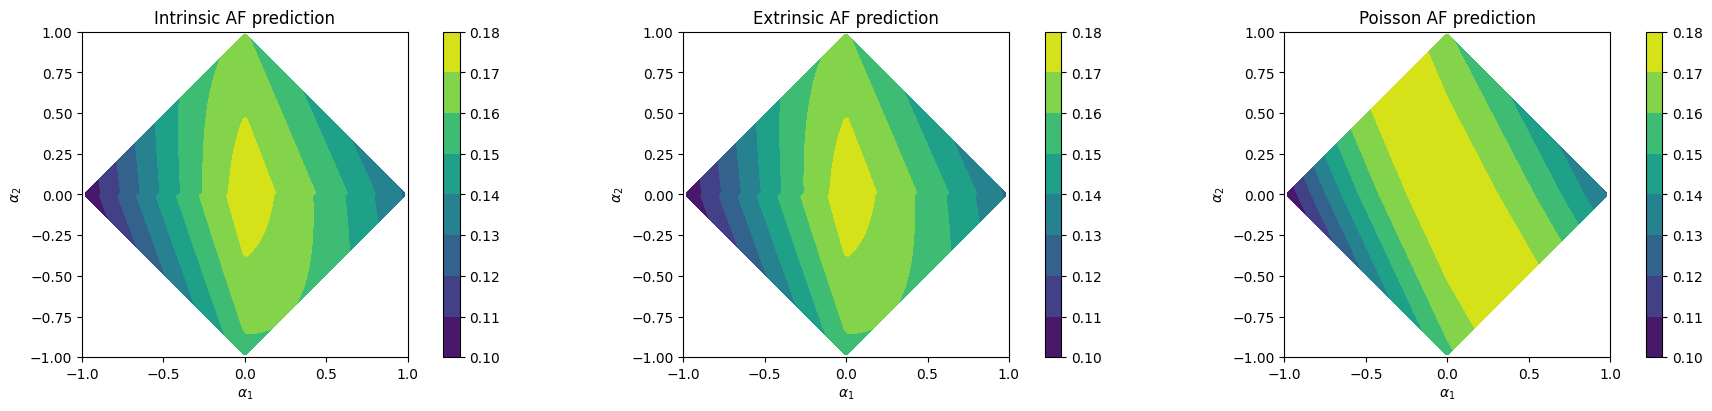

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)

im1 = axs[0].contourf(param_1_range, param_2_range, AF_pred_intrinsic)
axs[0].axis('scaled')
axs[0].set_title("Intrinsic AF prediction")
axs[0].set_xlabel(r"$\alpha_1$")
axs[0].set_ylabel(r"$\alpha_2$")
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].contourf(param_1_range, param_2_range, AF_pred_extrinsic)
axs[1].axis('scaled')
axs[1].set_title("Extrinsic AF prediction")
axs[1].set_xlabel(r"$\alpha_1$")
axs[1].set_ylabel(r"$\alpha_2$")
fig.colorbar(im2, ax=axs[1])

im2 = axs[2].contourf(param_1_range, param_2_range, AF_pred_poisson)
axs[2].axis('scaled')
axs[2].set_title("Poisson AF prediction")
axs[2].set_xlabel(r"$\alpha_1$")
axs[2].set_ylabel(r"$\alpha_2$")
fig.colorbar(im2, ax=axs[2])
